<a href="https://colab.research.google.com/github/samiha-mahin/Ovarian-cancer/blob/main/Multimodal_EfficientNetV2B3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"samihamuntahamahin","key":"1ad5aaba9143fbd38da418ad8d278398"}'}

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


!kaggle datasets list -s "ovarian cancer"

ref                                                             title                                                      size  lastUpdated                 downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  --------------------------------------------------  -----------  --------------------------  -------------  ---------  ---------------  
saurabhshahane/predict-ovarian-cancer                           Predict Ovarian Cancer                                   322564  2021-02-06 08:15:47.360000           2920         47  0.7058824        
yoshifumimiya/6-ovarian-cancer-datasets                         7 ovarian cancer datasets                             239456735  2024-04-21 13:37:49.933000           3571         49  0.7647059        
sunilthite/ovarian-cancer-classification-dataset                Ovarian Cancer Subtype Classification                3554471607  2023-10-31 08:34:17.390000           1652         39  1.0          

In [4]:
!kaggle datasets download -d bitsnpieces/ovarian-cancer-and-subtypes-dataset-histopathology --unzip

Dataset URL: https://www.kaggle.com/datasets/bitsnpieces/ovarian-cancer-and-subtypes-dataset-histopathology
License(s): CC-BY-SA-4.0


In [5]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B3, preprocess_input
from tensorflow.keras import layers, Input, Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam

# -----------------------------
# Load and preprocess image data
# -----------------------------
IMG_SIZE = 300
DATASET_PATH = "OvarianCancer"
classes = ["Mucinous", "Non_Cancerous", "Endometri", "Serous", "Clear_Cell"]
class_mapping = {name: i for i, name in enumerate(classes)}

X_images, y_labels = [], []

def augment_image(img):
    if np.random.rand() < 0.5:
        img = cv2.flip(img, 1)
    return img

for class_name in classes:
    folder = os.path.join(DATASET_PATH, class_name)
    if not os.path.exists(folder): continue
    for img_file in os.listdir(folder):
        img_path = os.path.join(folder, img_file)
        img = cv2.imread(img_path)
        if img is None: continue
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = augment_image(img)
        img = preprocess_input(img)
        X_images.append(img)
        y_labels.append(class_mapping[class_name])

X_images = np.array(X_images)
y_labels = to_categorical(y_labels, num_classes=len(classes))

# -----------------------------
# Load and preprocess tabular data
# -----------------------------
df = pd.read_csv("Ovarian_patient_data.csv")
df.columns = df.columns.str.strip().str.replace(" ", "_").str.lower()
features = ['age', 'ca125', 'cancerstage', 'bmi']
df = df.dropna(subset=features).reset_index(drop=True)
df = df.iloc[:len(X_images)]  # Ensure alignment

scaler = StandardScaler()
X_tabular = scaler.fit_transform(df[features].values)

# -----------------------------
# Train-test split
# -----------------------------
X_train_img, X_test_img, X_train_tab, X_test_tab, y_train, y_test = train_test_split(
    X_images, X_tabular, y_labels, test_size=0.2, random_state=42
)

# -----------------------------
# Build multimodal model
# -----------------------------
image_input = Input(shape=(IMG_SIZE, IMG_SIZE, 3), name="image_input")
base_model = EfficientNetV2B3(include_top=False, weights="imagenet", input_tensor=image_input, pooling="avg")
base_model.trainable = True
x = layers.Dense(256, activation="relu")(base_model.output)
x = layers.Dropout(0.4)(x)

tabular_input = Input(shape=(X_tabular.shape[1],), name="tabular_input")
y = layers.Dense(128, activation="relu")(tabular_input)
y = layers.BatchNormalization()(y)
y = layers.Dropout(0.3)(y)
y = layers.Dense(64, activation="relu")(y)
y = layers.BatchNormalization()(y)
y = layers.Dense(32, activation="relu")(y)

combined = layers.Concatenate()([x, y])
z = layers.Dense(256, activation='relu')(combined)
z = layers.Dropout(0.4)(z)
z = layers.Dense(128, activation='relu')(z)
z = layers.Dropout(0.3)(z)
output = layers.Dense(len(classes), activation='softmax')(z)

model = Model(inputs=[image_input, tabular_input], outputs=output)
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=["accuracy"]
)

# -----------------------------
# Callbacks
# -----------------------------
checkpoint = ModelCheckpoint("best_model_b3.h5", monitor="val_accuracy", save_best_only=True, mode="max", verbose=1)
lr_reducer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
early_stop = EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True)

# -----------------------------
# Train
# -----------------------------
history = model.fit(
    [X_train_img, X_train_tab],
    y_train,
    validation_data=([X_test_img, X_test_tab], y_test),
    epochs=25,
    batch_size=8,
    callbacks=[checkpoint, lr_reducer, early_stop]
)

# -----------------------------
# Evaluate
# -----------------------------
model.load_weights("best_model_b3.h5")
loss, acc = model.evaluate([X_test_img, X_test_tab], y_test)
print(f"\n✅ Best Accuracy with EfficientNetV2B3: {acc * 100:.2f}%")


52606240/52606240 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2405 - loss: 1.6219
Epoch 1: val_accuracy improved from -inf to 0.41000, saving model to best_model_b3.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 258s 4s/step - accuracy: 0.2409 - loss: 1.6221 - val_accuracy: 0.4100 - val_loss: 1.5748 - learning_rate: 1.0000e-04
Epoch 2/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2832 - loss: 1.5814
Epoch 2: val_accuracy improved from 0.41000 to 0.52000, saving model to best_model_b3.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 188s 4s/step - accuracy: 0.2838 - loss: 1.5807 - val_accuracy: 0.5200 - val_loss: 1.4824 - learning_rate: 1.0000e-04
Epoch 3/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4235 - loss: 1.4431
Epoch 3: val_accuracy did not improve from 0.52000
50/50 ━━━━━━━━━━━━━━━━━━━━ 187s 4s/step - accuracy: 0.4242 - loss: 1.4424 - val_accuracy: 0.4200 - val_loss: 1.4412 - learning_rate: 1.0000e-04
Epoch 4/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4946 - loss: 1.3219
Epoch 4: val_accuracy improved from 0.52000 to 0.56000, saving model to best_model_b3.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 193s 4s/step - accuracy: 0.4949 - loss: 1.3217 - val_accuracy: 0.5600 - val_loss: 1.2868 - learning_rate: 1.0000e-04
Epoch 5/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6472 - loss: 1.1845
Epoch 5: val_accuracy improved from 0.56000 to 0.62000, saving model to best_model_b3.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 212s 4s/step - accuracy: 0.6468 - loss: 1.1844 - val_accuracy: 0.6200 - val_loss: 1.1377 - learning_rate: 1.0000e-04
Epoch 6/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6663 - loss: 1.0435
Epoch 6: val_accuracy improved from 0.62000 to 0.73000, saving model to best_model_b3.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 189s 4s/step - accuracy: 0.6664 - loss: 1.0431 - val_accuracy: 0.7300 - val_loss: 1.0029 - learning_rate: 1.0000e-04
Epoch 7/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7217 - loss: 0.9273
Epoch 7: val_accuracy improved from 0.73000 to 0.79000, saving model to best_model_b3.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 208s 4s/step - accuracy: 0.7224 - loss: 0.9267 - val_accuracy: 0.7900 - val_loss: 0.9081 - learning_rate: 1.0000e-04
Epoch 8/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8305 - loss: 0.8012
Epoch 8: val_accuracy improved from 0.79000 to 0.84000, saving model to best_model_b3.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 199s 4s/step - accuracy: 0.8305 - loss: 0.8009 - val_accuracy: 0.8400 - val_loss: 0.7981 - learning_rate: 1.0000e-04
Epoch 9/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8769 - loss: 0.7216
Epoch 9: val_accuracy improved from 0.84000 to 0.86000, saving model to best_model_b3.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 202s 4s/step - accuracy: 0.8769 - loss: 0.7222 - val_accuracy: 0.8600 - val_loss: 0.7029 - learning_rate: 1.0000e-04
Epoch 10/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8597 - loss: 0.7184
Epoch 10: val_accuracy did not improve from 0.86000
50/50 ━━━━━━━━━━━━━━━━━━━━ 214s 4s/step - accuracy: 0.8600 - loss: 0.7182 - val_accuracy: 0.8300 - val_loss: 0.7214 - learning_rate: 1.0000e-04
Epoch 11/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9124 - loss: 0.6842
Epoch 11: val_accuracy did not improve from 0.86000
50/50 ━━━━━━━━━━━━━━━━━━━━ 271s 4s/step - accuracy: 0.9125 - loss: 0.6837 - val_accuracy: 0.8600 - val_loss: 0.6891 - learning_rate: 1.0000e-04
Epoch 12/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9276 - loss: 0.6337
Epoch 12: val_accuracy did not improve from 0.86000

Epoch 12: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
50/50 ━━━━━━━━━━━━━━━━━━━━ 265s 4s/step - accuracy: 0.9273 - loss: 0.6339 - val_ac

50/50 ━━━━━━━━━━━━━━━━━━━━ 242s 4s/step - accuracy: 0.9614 - loss: 0.5706 - val_accuracy: 0.8700 - val_loss: 0.6883 - learning_rate: 5.0000e-05
Epoch 15/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9623 - loss: 0.5568
Epoch 15: val_accuracy did not improve from 0.87000
50/50 ━━━━━━━━━━━━━━━━━━━━ 195s 4s/step - accuracy: 0.9625 - loss: 0.5568 - val_accuracy: 0.8700 - val_loss: 0.6991 - learning_rate: 5.0000e-05
Epoch 16/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9606 - loss: 0.5942
Epoch 16: val_accuracy did not improve from 0.87000
50/50 ━━━━━━━━━━━━━━━━━━━━ 203s 4s/step - accuracy: 0.9607 - loss: 0.5938 - val_accuracy: 0.8600 - val_loss: 0.7176 - learning_rate: 5.0000e-05
Epoch 17/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9783 - loss: 0.5205
Epoch 17: val_accuracy did not improve from 0.87000

Epoch 17: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
50/50 ━━━━━━━━━━━━━━━━━━━━ 202s 4s/step - accuracy: 0.9782 - loss: 0.5206 - val_ac

4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step


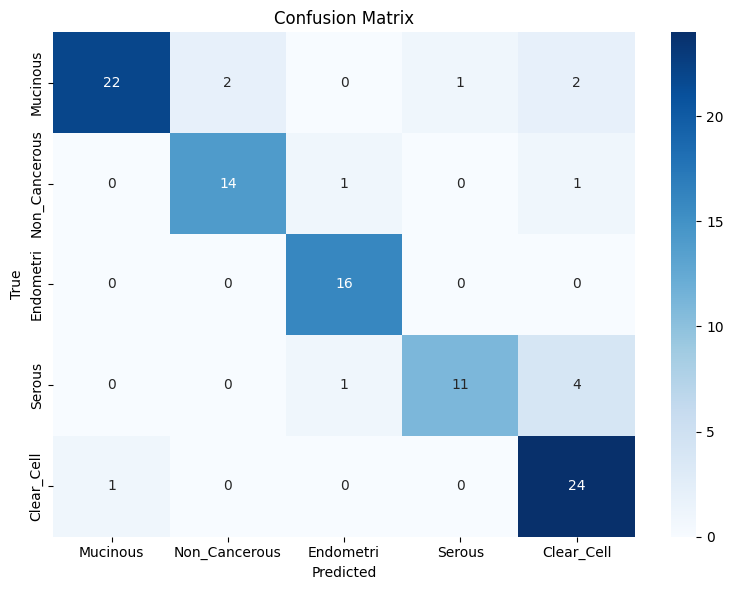


Classification Report:

               precision    recall  f1-score   support

     Mucinous       0.96      0.81      0.88        27
Non_Cancerous       0.88      0.88      0.88        16
    Endometri       0.89      1.00      0.94        16
       Serous       0.92      0.69      0.79        16
   Clear_Cell       0.77      0.96      0.86        25

     accuracy                           0.87       100
    macro avg       0.88      0.87      0.87       100
 weighted avg       0.88      0.87      0.87       100



In [6]:
# -----------------------------
# Plot confusion matrix
# -----------------------------
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predict classes
y_pred_probs = model.predict([X_test_img, X_test_tab])
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
class_names = classes

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# Classification report (optional, but useful)
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))
